## Background ##

We have a data file containing records corresponding to surgical cases. For each case we know some basic information about the patient's scheduled case including an urgency code, 
the date the case was scheduled, insurance status, surgical service, and the number of days prior to surgery in which the case was scheduled. In data model terms, the first 4 variables 
are dimensions and the last variable is a measure. Of course, we could certainly use things like SQL or Excel Pivot Tables to do very useful things with this data. 
In a [previous tutorial](https://drupal.improvementpath.com/drupal/node/1) I showed how R can be used to do the same things as well as to do some things that are much more difficult using SQL or Excel. In [another related tutorial I did the same things as in the R tutorial but used Python instead](http://hselab.org/content/getting-started-python-pandas-and-matplotlib-group-analysis). Since many business analytics folks end up using both R and Python, it is important to be able to switch your brain between R and Python modes.

In this short tutorial, I'll show how to use `rmagic` from within an IPython notebook so that we can make plots using `ggplot2`. In particular, we want to create a grid of histograms with the vertical grid axis being surgical service and the horizontal axis being day of week. We want to make sure that the plots are ordered Sunday, Monday, ..., Saturday and NOT in alphabetical order (Friday, Monday, ..., Wednesday).


Exploring rmagic
----------------

The *rmagic* extension allows us to magically use R from within IPython.

http://nbviewer.ipython.org/github/ipython/ipython/blob/3607712653c66d63e0d7f13f073bde8c0f209ba8/docs/examples/notebooks/rmagic_extension.ipynb

After loading the `rmagic` extension, you can use `%R` for a single R *line magic* command or `%%R` for *cell magic* to handle a sequence of R commands.

In [2]:
# Load the extension
%load_ext rpy2.ipython

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Make the graphs a bit prettier, and bigger
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60) 

In [7]:
%matplotlib inline

Read the data and about the basic data structures
-------------------------------------------------

One of he main data structures in pandas is the `DataFrame`. It's similar to a data frame in R and you can think of it as just a data table with field names and an index. An index is just a set of row labels and by default will just be an integer sequence starting at 0. However, Pandas takes great pains to be smart in the way it uses these indexes. Here's a quote from the documentation:

> Here is a basic tenet to keep in mind: data alignment is intrinsic. The link between labels and data will not be broken  unless done so explicitly by you.

This tenet will make it easy for us to do things like joining separate data structures on their indexes and automatically aligning data structures even if one of them has "missing rows".

A really nice tutorial for learning about Pandas data structures, written for those coming with a SQL background is [http://www.gregreda.com/2013/10/26/intro-to-pandas-data-structures/](http://www.gregreda.com/2013/10/26/intro-to-pandas-data-structures/). You should definitely take a look at this tutorial (and ideally create a notebook and work along with it).


Ok, here we go. A simple way to create a data frame is to read a csv file into pandas with the `read_csv` function. Like the `read.csv` function in R, there are numerous parameters for doing things like specifying the delimiter, dealing with quoted text, indicating whether or not a header line exists, or passing in a list of desired column names. The [IO Tools section of the documentation](http://pandas.pydata.org/pandas-docs/dev/io.html) has all the details.

In [8]:
sched_df = pd.read_csv('SchedDaysAdv.csv')

In [9]:
# Typing the name of the dataframe will either get you some rows or info about the structure.
sched_df

PatientID          SurgeryDate                  Service  ScheduledDaysInAdvance    Urgency InsuranceStatus
0              0  2012-07-05 00:00:00               Cardiology                       9    Routine         Private
1              1  2009-10-08 00:00:00                 Podiatry                      34    Routine         Private
2              2  2009-06-11 00:00:00  Oral-Maxillofacial Surg                      22    Routine         Private
3              3  2011-02-18 00:00:00          General Surgery                       1     Urgent         Private
4              4  2012-08-20 00:00:00       Orthopedic Surgery                      14    Routine         Private
5              5  2010-12-16 00:00:00          General Surgery                      38    Routine        Medicare
6              6  2009-12-21 00:00:00       Orthopedic Surgery                      10    Routine         Private
7              7  2009-03-24 00:00:00              GYN Surgery                      34    Routine         Private
8              8  2009-11-25 00:00:00       Urology/GU Surgery                      25    Routine         Private
9              9  2009-10-01 00:00:00          General Surgery                      12    Routine        Medicaid
10            10  2010-10-11 00:00:00          General Surgery                      36    Routine         Private
11            11  2009-12-17 00:00:00                 Podiatry                      27    Routine        Medicaid
12            12  2011-03-25 00:00:00           Otolaryngology                      55    Routine            None
13            13  2012-12-24 00:00:00                 Podiatry                      29    Routine            None
14            14  2009-10-07 00:00:00  Oral-Maxillofacial Surg                      18    Routine            None
15            15  2012-10-30 00:00:00       Orthopedic Surgery                      28    Routine            None
16            16  2010-10-12 00:00:00          General Surgery                      12    Routine        Medicare
17            17  2010-09-27 00:00:00          General Surgery                       4     Urgent         Private
18            18  2011-02-23 00:00:00         Gastroenterology                      29    Routine         Private
19            19  2009-04-22 00:00:00       Urology/GU Surgery                      12    Routine            None
20            20  2011-11-28 00:00:00       Orthopedic Surgery                      25    Routine         Private
21            21  2009-06-23 00:00:00           Otolaryngology                      34    Routine            None
22            22  2009-10-26 00:00:00  Oral-Maxillofacial Surg                      35    Routine            None
23            23  2010-10-07 00:00:00                 Podiatry                      16    Routine            None
24            24  2012-04-26 00:00:00       Orthopedic Surgery                      39    Routine         Private
25            25  2011-02-14 00:00:00              Pain Clinic                       7    Routine         Private
26            26  2012-09-10 00:00:00          General Surgery                      49    Routine        Medicare
27            27  2009-02-27 00:00:00          General Surgery                       5    Routine            None
28            28  2010-08-20 00:00:00           Otolaryngology                       9    Routine         Private
29            29  2012-12-27 00:00:00           Otolaryngology                      23    Routine            None
...          ...                  ...                      ...                     ...        ...             ...
19970      19970  2009-11-05 00:00:00  Oral-Maxillofacial Surg                       9    Routine         Private
19971      19971  2011-01-27 00:00:00              GYN Surgery                      22    Routine         Private
19972      19972  2010-07-06 00:00:00           Otolaryngology                       7    Routine         Private
19973      19973 

We can check out the structure of this dataframe with the `info()` function. Do a `help(info)` to learn more
about this handy function.

In [10]:
sched_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
PatientID                 20000 non-null int64
SurgeryDate               20000 non-null object
Service                   20000 non-null object
ScheduledDaysInAdvance    20000 non-null int64
Urgency                   20000 non-null object
InsuranceStatus           20000 non-null object
dtypes: int64(2), object(4)
memory usage: 937.6+ KB


Notice that a default index was created using an integer sequence from 0 to 19999. The index itself is an instance of a pandas `Int64Index` object. 

Just like an R `data.frame` was really just a collection of R `vector` objects (each having their own data type), a pandas `DataFrame` is a collection of `Series` objects. Each `Series` can have its own data type and a `Series` also has an index. So, a `DataFrame` is really a collection of `Series` objects with a shared index.

Also, it looks like the datetime field has been interpreted by pandas as an object.  There's pleny of trickiness and numerous details in working with dates and times in pandas. For now, let's just take a look at the dataframe and learn some basic techniques for referencing columns and rows. You'll see that it's very similar to what we did with R `data.frame` objects.

In [11]:
# Check out the first few rows of sched_df
sched_df.head() 

PatientID          SurgeryDate                  Service  ScheduledDaysInAdvance  Urgency InsuranceStatus
0          0  2012-07-05 00:00:00               Cardiology                       9  Routine         Private
1          1  2009-10-08 00:00:00                 Podiatry                      34  Routine         Private
2          2  2009-06-11 00:00:00  Oral-Maxillofacial Surg                      22  Routine         Private
3          3  2011-02-18 00:00:00          General Surgery                       1   Urgent         Private
4          4  2012-08-20 00:00:00       Orthopedic Surgery                      14  Routine         Private

In [12]:
# Check out the last few rows.
sched_df.tail() 

PatientID          SurgeryDate                  Service  ScheduledDaysInAdvance    Urgency InsuranceStatus
19995      19995  2011-04-26 00:00:00              GYN Surgery                      36    Routine         Private
19996      19996  2009-07-17 00:00:00  Oral-Maxillofacial Surg                      22    Routine         Private
19997      19997  2010-11-02 00:00:00              GYN Surgery                      50    Routine            None
19998      19998  2012-12-20 00:00:00          General Surgery                      21    Routine        Medicare
19999      19999  2012-07-26 00:00:00               Obstetrics                       1  Emergency         Private

In [13]:
# Number of rows and columns?
sched_df.shape

(20000, 6)

Selecting columns and rows
--------------------------

Much like with R `data.frame` objects, there are multiple ways of selecting subsets of a pandas `DataFrame`. 


### Rows

We saw about that `head` and `tail` return 5 rows from the beginning and end of the data frame. To get a specific number:

In [14]:
# First 10
sched_df.head(10)

PatientID          SurgeryDate                  Service  ScheduledDaysInAdvance  Urgency InsuranceStatus
0          0  2012-07-05 00:00:00               Cardiology                       9  Routine         Private
1          1  2009-10-08 00:00:00                 Podiatry                      34  Routine         Private
2          2  2009-06-11 00:00:00  Oral-Maxillofacial Surg                      22  Routine         Private
3          3  2011-02-18 00:00:00          General Surgery                       1   Urgent         Private
4          4  2012-08-20 00:00:00       Orthopedic Surgery                      14  Routine         Private
5          5  2010-12-16 00:00:00          General Surgery                      38  Routine        Medicare
6          6  2009-12-21 00:00:00       Orthopedic Surgery                      10  Routine         Private
7          7  2009-03-24 00:00:00              GYN Surgery                      34  Routine         Private
8          8  2009-11-25 00:00:00       Urology/GU Surgery                      25  Routine         Private
9          9  2009-10-01 00:00:00          General Surgery                      12  Routine        Medicaid

In [15]:
# Last 7
sched_df.tail(7)

PatientID          SurgeryDate                  Service  ScheduledDaysInAdvance    Urgency InsuranceStatus
19993      19993  2011-01-12 00:00:00         Gastroenterology                      52    Routine        Medicaid
19994      19994  2010-10-15 00:00:00  Oral-Maxillofacial Surg                      11    Routine         Private
19995      19995  2011-04-26 00:00:00              GYN Surgery                      36    Routine         Private
19996      19996  2009-07-17 00:00:00  Oral-Maxillofacial Surg                      22    Routine         Private
19997      19997  2010-11-02 00:00:00              GYN Surgery                      50    Routine            None
19998      19998  2012-12-20 00:00:00          General Surgery                      21    Routine        Medicare
19999      19999  2012-07-26 00:00:00               Obstetrics                       1  Emergency         Private

You can also use Python "index slicing" just as we did with Numpy arrays. Remember your slicing rules... Think about what the next command will do before trying it. Also notice the output style difference when using `print`.

In [16]:
print (sched_df[1:4])

   PatientID          SurgeryDate                  Service  ScheduledDaysInAdvance  Urgency InsuranceStatus
1          1  2009-10-08 00:00:00                 Podiatry                      34  Routine         Private
2          2  2009-06-11 00:00:00  Oral-Maxillofacial Surg                      22  Routine         Private
3          3  2011-02-18 00:00:00          General Surgery                       1   Urgent         Private


### Columns

You can select columns by name. As you might expect, if you select a single column you get a `Series` object and if you select more than one column you are getting a `DataFrame` object. To select multiple columns, pass in a list of column names.

In [17]:
sched_df['ScheduledDaysInAdvance'].head()

0     9
1    34
2    22
3     1
4    14
Name: ScheduledDaysInAdvance, dtype: int64

In [18]:
# What is the data type of a single column from a data frame?
type(sched_df['ScheduledDaysInAdvance'])

pandas.core.series.Series

In [19]:
# See data type for a data frame

In [20]:
# You can also reference column names like attributes, and yes, tab completion works.
sched_df.ScheduledDaysInAdvance.head()

0     9
1    34
2    22
3     1
4    14
Name: ScheduledDaysInAdvance, dtype: int64

In [21]:
# To select two columns, use a list of column names.
sched_df[['PatientID','ScheduledDaysInAdvance']].head()

PatientID  ScheduledDaysInAdvance
0          0                       9
1          1                      34
2          2                      22
3          3                       1
4          4                      14

In [22]:
# Combining row and column selection using the above methods looks like this. Notice
# that the syntax is df[rows][cols].
sched_df[0:4][['PatientID','ScheduledDaysInAdvance']]

PatientID  ScheduledDaysInAdvance
0          0                       9
1          1                      34
2          2                      22
3          3                       1

Note, this is different from the way we referenced elements in a 2D numpy array - x[rows to select,cols to select]. A `DataFrame` is not a 2D array (which it can't be of course - why?). It's really more like a dictionary of `Series` objects with the key being the column name.

### Boolean indexing

Again, just like we did in R, we can select rows using logical vectors. For example to select all the rows for which Service is 'Podiatry':

In [23]:
sched_df[sched_df.Service == 'Podiatry']

PatientID          SurgeryDate   Service  ScheduledDaysInAdvance  Urgency InsuranceStatus
1              1  2009-10-08 00:00:00  Podiatry                      34  Routine         Private
11            11  2009-12-17 00:00:00  Podiatry                      27  Routine        Medicaid
13            13  2012-12-24 00:00:00  Podiatry                      29  Routine            None
23            23  2010-10-07 00:00:00  Podiatry                      16  Routine            None
38            38  2012-11-29 00:00:00  Podiatry                      14  Routine            None
111          111  2009-07-15 00:00:00  Podiatry                      38  Routine         Private
138          138  2012-08-13 00:00:00  Podiatry                       4  Routine            None
162          162  2012-11-01 00:00:00  Podiatry                      23  Routine            None
213          213  2011-09-08 00:00:00  Podiatry                      13  Routine         Private
236          236  2011-09-28 00:00:00  Podiatry                       5  Routine         Private
273          273  2012-08-01 00:00:00  Podiatry                      16  Routine         Private
283          283  2012-12-31 00:00:00  Podiatry                       3   Urgent            None
315          315  2011-05-25 00:00:00  Podiatry                      20  Routine         Private
325          325  2012-09-27 00:00:00  Podiatry                       3  Routine            None
365          365  2012-08-29 00:00:00  Podiatry                      19  Routine            None
370          370  2010-07-22 00:00:00  Podiatry                      13  Routine         Private
377          377  2009-07-29 00:00:00  Podiatry                      23  Routine         Private
379          379  2012-08-08 00:00:00  Podiatry                      17  Routine        Medicaid
410          410  2009-12-03 00:00:00  Podiatry                      34  Routine         Private
466          466  2010-03-24 00:00:00  Podiatry                      21  Routine         Private
475          475  2010-07-14 00:00:00  Podiatry                      37  Routine         Private
485          485  2012-03-28 00:00:00  Podiatry                       9  Routine         Private
489          489  2010-03-31 00:00:00  Podiatry                      21  Routine         Private
504          504  2012-03-14 00:00:00  Podiatry                      24  Routine         Private
570          570  2012-10-31 00:00:00  Podiatry                      27  Routine            None
586          586  2011-03-16 00:00:00  Podiatry                      15  Routine         Private
594          594  2011-06-14 00:00:00  Podiatry                       1  Routine            None
618          618  2009-12-02 00:00:00  Podiatry                      38  Routine         Private
645          645  2009-05-05 00:00:00  Podiatry                       7  Routine         Private
651          651  2012-02-15 00:00:00  Podiatry                      38  Routine         Private
...          ...                  ...       ...                     ...      ...             ...
19362      19362  2011-02-24 00:00:00  Podiatry                      16  Routine         Private
19364      19364  2009-08-13 00:00:00  Podiatry                      30  Routine         Private
19376      19376  2009-07-22 00:00:00  Podiatry                      24  Routine         Private
19380      19380  2010-01-14 00:00:00  Podiatry                      37  Routine            None
19401      19401  2012-10-17 00:00:00  Podiatry                      11  Routine            None
19423      19423  2011-01-12 00:00:00  Podiatry                      26  Routine         Private
19516      19516  2011-06-22 00:00:00  Podiatry                      51  Routine         Private
19519      19519  2012-05-23 00:00:00  Podiatry                      49  Routine         Private
19578      19578  2012-12-24 00:00:00  Podiatry                      28  Routine            None
19606      19606  2010-10-28 0

You can combine conditions using the `&` (and) and `|` (or) operators. **IMPORTANT** Use parentheses around the logical clauses!

In [24]:
sched_df[sched_df.Service == 'Podiatry' & sched_df.Urgency == 'Urgent']

TypeError: cannot compare a dtyped [object] array with a scalar of type [bool]

In [25]:
sched_df[(sched_df.Service == 'Podiatry') & (sched_df.Urgency == 'Urgent')]

PatientID          SurgeryDate   Service  ScheduledDaysInAdvance Urgency InsuranceStatus
283          283  2012-12-31 00:00:00  Podiatry                       3  Urgent            None
2629        2629  2012-02-02 00:00:00  Podiatry                       3  Urgent        Medicaid
10421      10421  2012-11-28 00:00:00  Podiatry                       0  Urgent            None
18882      18882  2012-11-07 00:00:00  Podiatry                       4  Urgent            None

In [26]:
# You try it

# Select the PatientID, Service, InsuranceStatus and Urgency columns for those rows in which ScheduledDaysInAdvance is greater than 60.

This is just the tip of the iceberg in terms of indexing and selecting subsets of `DataFrame` and `Series` objects. Pandas provides functions such as `loc` for label based selection, `iloc` for positional selection and `ix` for mixed label and positional selection. This makes very sophisticated selection possible, especially in the case of hierarchical indexes. See the [Indexing and Selecting chapter of the official documentation](http://pandas.pydata.org/pandas-docs/dev/indexing.html). We'll return to this topic as needed. It is one of the strengths of Pandas.

### Histogram and box plot ###

A popular plotting module for Python is [matplotlib](http://matplotlib.org/). The project homepage has many links to resources for learning it, with a very good place to start
being the official [documentation](http://matplotlib.org/contents.html) and the [gallery of graphs](http://matplotlib.org/gallery.html). The are a few modes of using matplotlib. There is a **pyplot** mode which is particularly well suited for interactive plotting
in a Python shell like [IPython](http://ipython.org/) (much like one would work in Mathematica or MATLAB). You can also use matplotlib within Python scripts either with
the pyplot commands or via an objected oriented API (similar to [ggplot2](http://ggplot2.org/) for plotting in [R](http://www.r-project.org/)).

Here is a basic histogram for ScheduledDaysInAdvance. For a more API based approach, see [this example from the matplotlib page](http://matplotlib.org/examples/api/histogram_demo.html) as
well as the next version of our histogram below.

In [27]:
# normed=1 plots probs instead of counts, alpha in [0,1] is transparency level (RGBA colors)
plt.hist(sched_df['ScheduledDaysInAdvance'], 50, normed=1, facecolor='green', alpha=0.75) 
plt.xlabel('Days')
plt.ylabel('Probability')
plt.title(r'Histogram of Schedule Lead Time')
plt.axis([0, 200, 0, 0.06])
plt.grid(True)
plt.show()

Now, let's create the same plot, but using R's `ggplot2` package. Our basic strategy is:
- use the `%Rpush` command to "push" the sched_df `DataFrame` into the R workspace.
- use `%R` line magic to load the `ggplot2` library
- use `%%R` cell magic to create and show the plot

In [28]:
%Rpush sched_df

In [29]:
%R library(ggplot2)

array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'],
      dtype='<U9')

/home/mark/anaconda3/envs/hselab/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


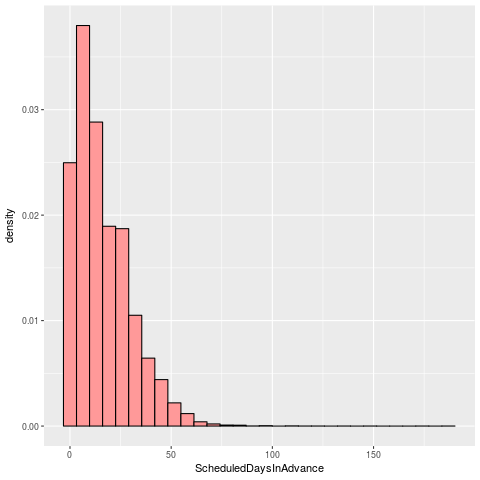

In [30]:
%%R
g <- ggplot(data=sched_df) + geom_histogram(aes(x=ScheduledDaysInAdvance, y=..density..), fill="#FF9999", colour="black")
print(g)

In [31]:
%R print(g + facet_wrap(~Urgency))

/home/mark/anaconda3/envs/hselab/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


TypeError: 'rpy2.rinterface.RNULLType' object is not iterable

R object with classes: ('list',) mapped to:
<ListVector - Python:0x7f9970b2d348 / R:0x6b83cf0>
[ListVector, Environment, ListVector]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x7f9970b2d348 / R:0x6b83cf0>
[ListVector, Environment, ListVector]
  layout: <class 'rpy2.robjects.environments.Environment'>
  R object with classes: ('Layout', 'ggproto') mapped to:
<Environment - Python:0x7f9970acd4c8 / R:0x659c508>
R object with classes: ('list',) mapped to:
<ListVector - Python:0x7f9970b2d348 / R:0x6b83cf0>
[ListVector, Environment, ListVector]

Now let's create some boxplots by day of week. Going to need the `lubridate` library to get day of week from the surgery date.

In [32]:
%R library(lubridate)

/home/mark/anaconda3/envs/hselab/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘lubridate’


  warnings.warn(x, RRuntimeWarning)
/home/mark/anaconda3/envs/hselab/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:base’:

    date


  warnings.warn(x, RRuntimeWarning)


array(['lubridate', 'ggplot2', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'],
      dtype='<U9')

We need to see if the SurgeryDate column got interpeted as a date by R.

In [33]:
%R str(sched_df)

'data.frame':	20000 obs. of  6 variables:
 $ PatientID             : int  0 1 2 3 4 5 6 7 8 9 ...
 $ SurgeryDate           : chr  "2012-07-05 00:00:00" "2009-10-08 00:00:00" "2009-06-11 00:00:00" "2011-02-18 00:00:00" ...
 $ Service               : chr  "Cardiology" "Podiatry" "Oral-Maxillofacial Surg" "General Surgery" ...
 $ ScheduledDaysInAdvance: int  9 34 22 1 14 38 10 34 25 12 ...
 $ Urgency               : chr  "Routine" "Routine" "Routine" "Urgent" ...
 $ InsuranceStatus       : chr  "Private" "Private" "Private" "Private" ...


Bummer, it came in as a factor. Let's fix that.

In [34]:
%%R 
sched_df$SurgeryDate <- as.POSIXlt(sched_df$SurgeryDate)
str(sched_df)

'data.frame':	20000 obs. of  6 variables:
 $ PatientID             : int  0 1 2 3 4 5 6 7 8 9 ...
 $ SurgeryDate           : POSIXlt, format: "2012-07-05" "2009-10-08" ...
 $ Service               : chr  "Cardiology" "Podiatry" "Oral-Maxillofacial Surg" "General Surgery" ...
 $ ScheduledDaysInAdvance: int  9 34 22 1 14 38 10 34 25 12 ...
 $ Urgency               : chr  "Routine" "Routine" "Routine" "Urgent" ...
 $ InsuranceStatus       : chr  "Private" "Private" "Private" "Private" ...


Now let's create a new column called DOW with a string version of the day of the week.

In [35]:
%R sched_df$DOW <- wday(sched_df$SurgeryDate, label=TRUE)

[Thurs, Thurs, Thurs, Fri, Mon, ..., Tues, Fri, Tues, Thurs, Thurs]
Length: 20000
Categories (7, object): [Sun < Mon < Tues < Wed < Thurs < Fri < Sat]

In [36]:
%R print(head(sched_df))

  PatientID SurgeryDate                 Service ScheduledDaysInAdvance Urgency
0         0  2012-07-05              Cardiology                      9 Routine
1         1  2009-10-08                Podiatry                     34 Routine
2         2  2009-06-11 Oral-Maxillofacial Surg                     22 Routine
3         3  2011-02-18         General Surgery                      1  Urgent
4         4  2012-08-20      Orthopedic Surgery                     14 Routine
5         5  2010-12-16         General Surgery                     38 Routine
  InsuranceStatus   DOW
0         Private Thurs
1         Private Thurs
2         Private Thurs
3         Private   Fri
4         Private   Mon
5        Medicare Thurs


A few things to note from the last two cells:
- even though we told the `wday` function to return day of week labels via the `label=TRUE` option, the underlying values returned are integers
- this happens because R is smart enough to automatically create the DOW column as an *ordered factor*. 
- when we look at the top few rows of sched_df, DOW does appear as a day of week label.
- to learn more about factors and levels and how they are stored in R, check out [this explanation](https://www.stat.berkeley.edu/classes/s133/factors.html).

The upside of this is, well, watch what happens when we create boxplots by day of week.

In [37]:
%%R
g3 <- ggplot(data=sched_df) + geom_boxplot(aes(x=DOW,y=ScheduledDaysInAdvance))
print(g3)

While this is perfect for our example, sometimes you have a dataset in which you might only have a character version of day of week and no date from which to create true ordered factors as we did above. Let's mimic this by creating a new column which is simply a character version of DOW.

In [38]:
%R sched_df$DOWchar <- as.character(sched_df$DOW)

array(['Thurs', 'Thurs', 'Thurs', ..., 'Tues', 'Thurs', 'Thurs'],
      dtype='<U5')

We see from the output above that we indeed are getting strings in this new column. Now, recreate the boxplots.

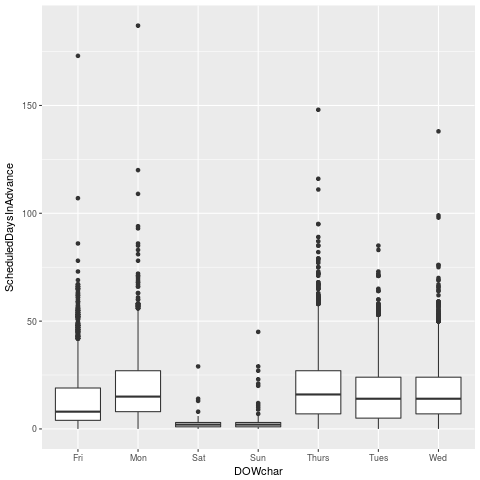

In [39]:
%%R
g4 <- ggplot(data=sched_df) + geom_boxplot(aes(x=DOWchar,y=ScheduledDaysInAdvance))
print(g4)

Doh! Now the days of the week are ordered alphabetically. What does one do in this case? We can convert DOWchar to an ordered character pretty easily by specifying the ordering.

In [40]:
# Show that DOWchar is NOT a factor
%R str(sched_df)

'data.frame':	20000 obs. of  8 variables:
 $ PatientID             : int  0 1 2 3 4 5 6 7 8 9 ...
 $ SurgeryDate           : POSIXlt, format: "2012-07-05" "2009-10-08" ...
 $ Service               : chr  "Cardiology" "Podiatry" "Oral-Maxillofacial Surg" "General Surgery" ...
 $ ScheduledDaysInAdvance: int  9 34 22 1 14 38 10 34 25 12 ...
 $ Urgency               : chr  "Routine" "Routine" "Routine" "Urgent" ...
 $ InsuranceStatus       : chr  "Private" "Private" "Private" "Private" ...
 $ DOW                   : Ord.factor w/ 7 levels "Sun"<"Mon"<"Tues"<..: 5 5 5 6 2 5 2 3 4 5 ...
 $ DOWchar               : chr  "Thurs" "Thurs" "Thurs" "Fri" ...


In [41]:
%%R
# Create vector with DOWs ordered as you wish
DOW_order <- c("Sun", "Mon", "Tues", "Wed", "Thurs", "Fri", "Sat")

# Change DOW from factor to ordered factor using vector you just made
sched_df$DOWchar <- factor(sched_df$DOWchar,levels=DOW_order,ordered=TRUE)

In [42]:
# Show that DOWchar is an ordered factor
%R str(sched_df)

'data.frame':	20000 obs. of  8 variables:
 $ PatientID             : int  0 1 2 3 4 5 6 7 8 9 ...
 $ SurgeryDate           : POSIXlt, format: "2012-07-05" "2009-10-08" ...
 $ Service               : chr  "Cardiology" "Podiatry" "Oral-Maxillofacial Surg" "General Surgery" ...
 $ ScheduledDaysInAdvance: int  9 34 22 1 14 38 10 34 25 12 ...
 $ Urgency               : chr  "Routine" "Routine" "Routine" "Urgent" ...
 $ InsuranceStatus       : chr  "Private" "Private" "Private" "Private" ...
 $ DOW                   : Ord.factor w/ 7 levels "Sun"<"Mon"<"Tues"<..: 5 5 5 6 2 5 2 3 4 5 ...
 $ DOWchar               : Ord.factor w/ 7 levels "Sun"<"Mon"<"Tues"<..: 5 5 5 6 2 5 2 3 4 5 ...


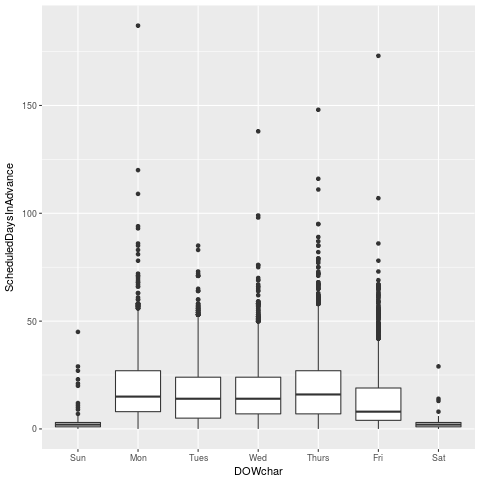

In [43]:
%%R
g4 <- ggplot(data=sched_df) + geom_boxplot(aes(x=DOWchar,y=ScheduledDaysInAdvance))
print(g4)

And now we've got the DOW ordering we really wanted.

Finally, let's create a grid of boxplots.

In [44]:
%%R
g5 <- g4 + facet_grid(Urgency ~ .)
print(g5)

Hmm, let's try it the other way.

In [45]:
%%R
g6 <- g4 + facet_grid(. ~ Urgency)
print(g6)

We'd need to do some axis label tweaking. Instead, let's end with an additional variable in the `facet_grid` function.

In [46]:
%%R
g7 <- g4 + facet_grid(Urgency ~ InsuranceStatus)
print(g7)